In [1]:
using Revise
using MDToolbox, Plots, JLD2, Printf, DelimitedFiles, BenchmarkTools

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/seica/.julia/packages/Revise/Pcs5V/src/Revise.jl:1217


In [2]:
q_array = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
model_array = []
push!(model_array, decenter!(readpdb("data/CCA.pdb")))
push!(model_array, decenter!(readpdb("data/CCR.pdb")))
push!(model_array, decenter!(readpdb("data/OOA.pdb")))
push!(model_array, decenter!(readpdb("data/OOR.pdb")))

size(model_array)

(4,)

In [3]:
test_config = MDToolbox.defaultConfig()

test_config.range_min = MDToolbox.Point2D(-95, -95)
test_config.range_max = MDToolbox.Point2D(105, 105)
test_config.probeRadius = 13

13

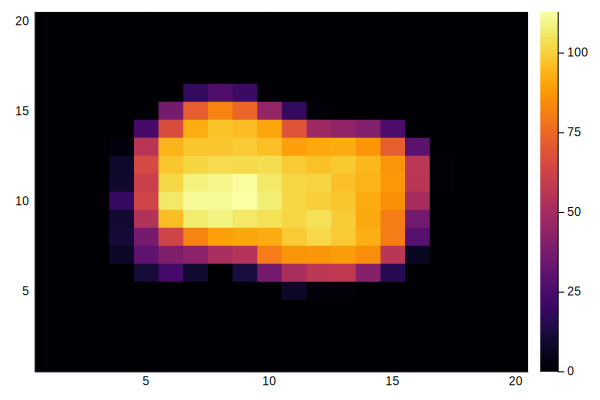

In [4]:
test_model =  MDToolbox.rotate(model_array[3], q_array[333, :])
test_frame = MDToolbox.afmize(test_model, test_config)
heatmap(test_frame)

In [5]:
@time result = MDToolbox.calcAfmPosterior(test_frame, model_array, q_array, [10, 20], MDToolbox.defaultConfig())

100.897200 seconds (1.81 G allocations: 41.906 GiB, 6.19% gc time)


MDToolbox.posteriorResult([3.052915004216821e-18, 0.9871355052282087, 6.277454768066398e-13, 0.012864494771163469], -860.362680461978, 1x1044 TrjArray
| X                          |  …   X                          |
| 1THR                       |  …   1044SER                    |
| 1CA                        |  …   1044CA                     |
|    25.00   -30.66     8.83 |  …     -34.22    63.00     7.38 |, [-0.53340212, 0.22094212, -0.31246012, -0.75434412], 10)

[3.052915004216821e-18, 0.9871355052282087, 6.277454768066398e-13, 0.012864494771163469]
-860.362680461978
10


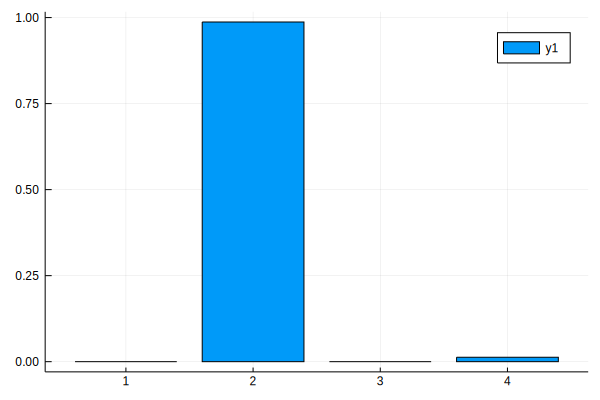

In [6]:
println(result.posteriors)
println(result.best_posterior)
println(result.best_radius)
bar(result.posteriors)